In [1]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [4]:
dataset = load_dataset("ahmedheakl/arocrbench_synthesizear",split="train")

In [5]:
dataset

Dataset({
    features: ['image', 'text', 'source'],
    num_rows: 500
})

In [6]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["text"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qwenv2.5_3B": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 500 samples.


## Qwenvl2.5 3B 

In [7]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct",torch_dtype="auto",device_map="cuda:0")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
from PIL import Image 
import requests

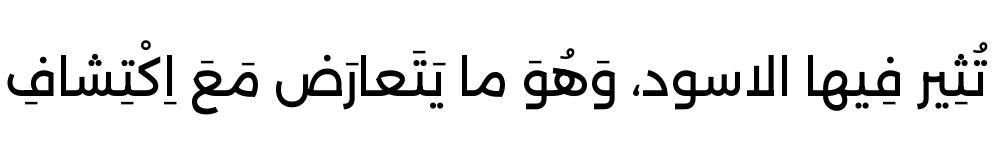

In [9]:
image = dataset[2]['image']
image

In [10]:
dataset[2]['text']

'تُثِير فِيها الاسود، وَهُوَ ما يَتَعارَض مَعَ اِكْتِشافِ'

In [11]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "extract the arabic text in the following image"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [12]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


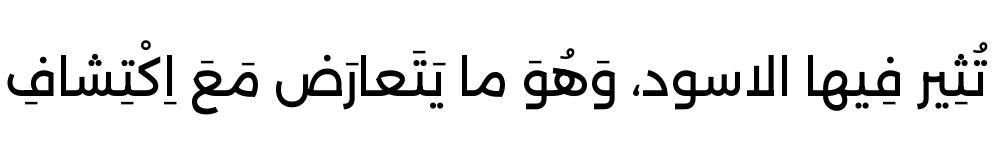

In [16]:
image = dataset[2]['image']
image

In [15]:
qwen_extract_ocr(text_prompt,image=dataset[2]['image'])


['The Arabic text in the image is:\n\nتُثير فيها الأسود، وهو ما يتعارض مع اكتشاف']

In [18]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image'].resize((512,512))
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image)).replace("The Arabic text in the image is:\n\n","")
    print(text_result)
    print("*****"*40)
    results[i]['qwenv2.5_3B'] = text_result

وَإِذا ما سَأَلْتَنِي عَن مَعْنَى لَفظَةٍ "عُرب" عِندَ
********************************************************************************************************************************************************************************************************
أَنْ تُفْهَمَ النُّصُوصِ وَإِسْتِنْبَاطُ مَعْنَاهَا يُوجَدُ صَحِيحٌ تَفَقِيقٌ
********************************************************************************************************************************************************************************************************
"تُظهر فيها الأسود، وهو ما يتغافض مع اكتشاف"
********************************************************************************************************************************************************************************************************
الجماعي، وظلت تصل إلى المرحلة الاشتراكية لسيطرة أكبر
**********************************************************************************************************************************************************************

In [22]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [28]:
df = pd.DataFrame(results)
df.head()

,image,ground_truth,qwenv2.5_3B
0,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x114 at 0x7DB0F6777E90>,"وَإِذا ما سَأَلَتْنِي عَن مَعْنَى لَفَظَهُ ""عرب"" عِنْدَ","وَإِذا ما سَأَلْتَنِي عَن مَعْنَى لَفظَةٍ ""عُرب"" عِندَ"
1,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1182x147 at 0x7DB0F6776E90>,أَمّا فَهُم النُصُوصِ وَاِسْتِنْباط مَعانِيها بِوَجْهٍ صَحِيحٌ دقيق،,أَنْ تُفْهَمَ النُّصُوصِ وَإِسْتِنْبَاطُ مَعْنَاهَا يُوجَدُ صَحِيحٌ تَفَقِيقٌ
2,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=994x163 at 0x7DB0F67E6650>,تُثِير فِيها الاسود، وَهُوَ ما يَتَعارَض مَعَ اِكْتِشافِ,"""تُظهر فيها الأسود، وهو ما يتغافض مع اكتشاف"""
3,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1315x224 at 0x7DB0F67E6B10>,الجماعي، وَكادَت تَصِل إِلَى المَرْحَلَةِ الاِشْتِراكِيَّة لِسَيْطَرَةِ أَكْبَرَ,الجماعي، وظلت تصل إلى المرحلة الاشتراكية لسيطرة أكبر
4,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1224x129 at 0x7DB0F67E6FD0>,مَعَهُ مَنْدِيلا فِيهِ جردقتان وَقَطَعَ لَحْم سَكْباج مُبَرَّد,مَا هُوَ مُنْبِذٌ فِيهِ دَرَقَاتٍ وَفَطْعَ أَحْمَسْخَاجٍ مُّرْتَدٌ


In [29]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters)
df['qwenv2.5_3B'] = df['qwenv2.5_3B'].apply(remove_english_letters)

In [30]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qwenv2.5_3B_t'] = df["qwenv2.5_3B"].apply(remove_diacritics)


In [31]:
df.head()

,image,ground_truth,qwenv2.5_3B,ground_truth_t,qwenv2.5_3B_t
0,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x114 at 0x7DB0F6777E90>,"وَإِذا ما سَأَلَتْنِي عَن مَعْنَى لَفَظَهُ ""عرب"" عِنْدَ","وَإِذا ما سَأَلْتَنِي عَن مَعْنَى لَفظَةٍ ""عُرب"" عِندَ","وإذا ما سألتني عن معنى لفظه ""عرب"" عند","وإذا ما سألتني عن معنى لفظة ""عرب"" عند"
1,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1182x147 at 0x7DB0F6776E90>,أَمّا فَهُم النُصُوصِ وَاِسْتِنْباط مَعانِيها بِوَجْهٍ صَحِيحٌ دقيق،,أَنْ تُفْهَمَ النُّصُوصِ وَإِسْتِنْبَاطُ مَعْنَاهَا يُوجَدُ صَحِيحٌ تَفَقِيقٌ,أما فهم النصوص واستنباط معانيها بوجه صحيح دقيق،,أن تفهم النصوص وإستنباط معناها يوجد صحيح تفقيق
2,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=994x163 at 0x7DB0F67E6650>,تُثِير فِيها الاسود، وَهُوَ ما يَتَعارَض مَعَ اِكْتِشافِ,"""تُظهر فيها الأسود، وهو ما يتغافض مع اكتشاف""",تثير فيها الاسود، وهو ما يتعارض مع اكتشاف,"""تظهر فيها الأسود، وهو ما يتغافض مع اكتشاف"""
3,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1315x224 at 0x7DB0F67E6B10>,الجماعي، وَكادَت تَصِل إِلَى المَرْحَلَةِ الاِشْتِراكِيَّة لِسَيْطَرَةِ أَكْبَرَ,الجماعي، وظلت تصل إلى المرحلة الاشتراكية لسيطرة أكبر,الجماعي، وكادت تصل إلى المرحلة الاشتراكية لسيطرة أكبر,الجماعي، وظلت تصل إلى المرحلة الاشتراكية لسيطرة أكبر
4,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1224x129 at 0x7DB0F67E6FD0>,مَعَهُ مَنْدِيلا فِيهِ جردقتان وَقَطَعَ لَحْم سَكْباج مُبَرَّد,مَا هُوَ مُنْبِذٌ فِيهِ دَرَقَاتٍ وَفَطْعَ أَحْمَسْخَاجٍ مُّرْتَدٌ,معه منديلا فيه جردقتان وقطع لحم سكباج مبرد,ما هو منبذ فيه درقات وفطع أحمسخاج مرتد


In [32]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qwenv2.5_3B"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qwenv2.5_3B - WER: 1.26, CER: 0.73


In [33]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qwenv2.5_3B_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qwenv2.5_3B_t - WER: 0.97, CER: 0.65


: 

In [15]:
df.to_csv("khattat_dl_synthesizear_result.csv")